In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import ast
from datetime import date, timedelta, datetime

# pip
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# DEV: override installed teslakit
import sys
sys.path.insert(0,'../../')

# teslakit 
from teslakit.project_site import Site
from teslakit.mjo import GetMJOCategories
from teslakit.plotting.mjo import Plot_MJOphases, Plot_MJOCategories
from teslakit.alr import ALR_WRP
from teslakit.io.aux_nc import StoreBugXdset as sbxds


# --------------------------------------
# Site paths and parameters
data_folder = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
site = Site(data_folder, 'KWAJALEIN')

ST = site.pc.site                      # site database
PR = site.params                       # site parameters

# input files: historical MJO
p_mjo_hist = op.join(data_folder, 'database', 'MJO', 'MJO_hist.nc')

# output files
p_mjo_alrw = ST.MJO.alrw               # MJO Autoregressive Logistic Regression
p_mjo_sim =  ST.MJO.sim                # simulated MJO

# export figs
p_export_mjo = ST.export_figs.mjo      # export figures


# MJO ALR parameters
alr_markov_order = int(PR.MJO.alr_markov)
alr_seasonality = ast.literal_eval(PR.MJO.alr_seasonality)

# Simulation dates (ALR)
d1_sim = np.datetime64(PR.SIMULATION.date_ini).astype(datetime)
d2_sim = np.datetime64(PR.SIMULATION.date_end).astype(datetime)


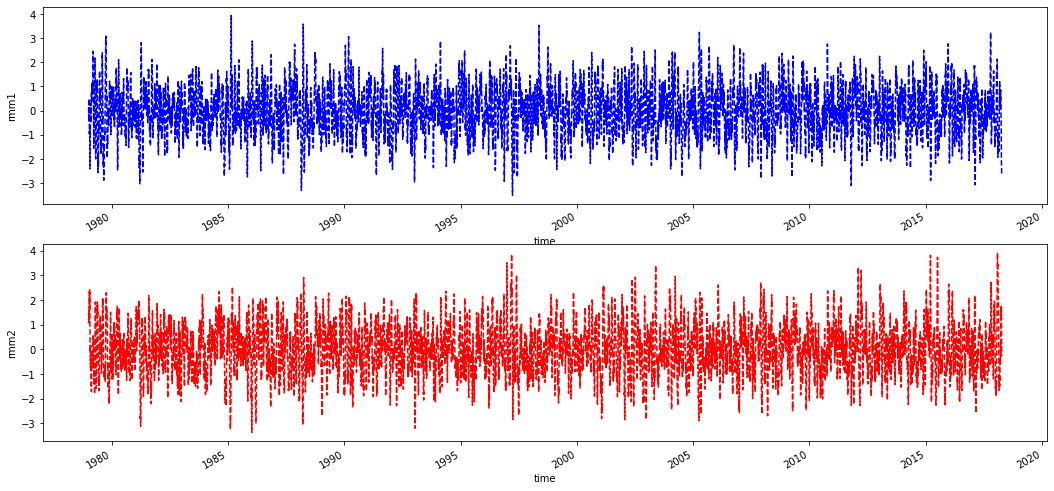

In [2]:
# --------------------------------------
# Load MJO data (previously downloaded)
xds_mjo_hist = xr.open_dataset(p_mjo_hist)
rmm1 = xds_mjo_hist['rmm1']
rmm2 = xds_mjo_hist['rmm2']
phase = xds_mjo_hist['phase']

# Plot MJO rmm1 and rmm2
fig, axes = plt.subplots(nrows=2, figsize=(18,8))
rmm1.plot.line('b--',ax=axes[0])
rmm2.plot.line('r--',ax=axes[1])




Calculating MJO categories (from 25 options)...


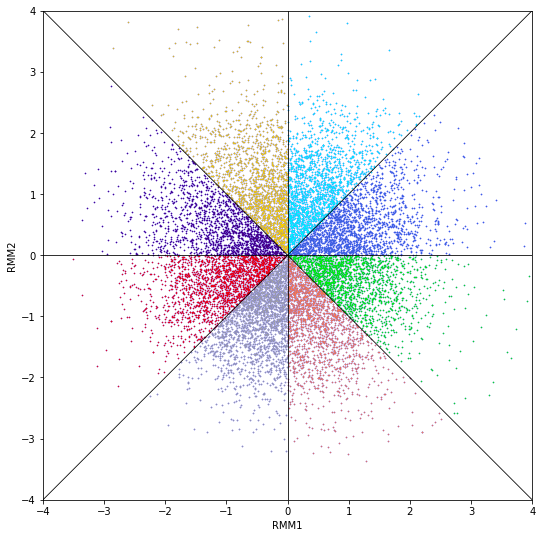

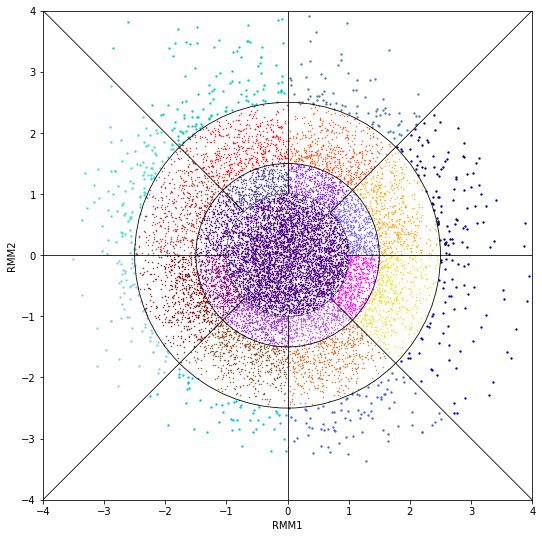

In [3]:
# --------------------------------------
# Calculate MJO categories (25 used) 
print('\nCalculating MJO categories (from 25 options)...')
categ, d_rmm_categ = GetMJOCategories(rmm1, rmm2, phase)
xds_mjo_hist['categ'] = (('time',), categ)

# plot MJO phases
Plot_MJOphases(rmm1, rmm2, phase)

# plot MJO categories
Plot_MJOCategories(rmm1, rmm2, categ)



Setting ALR execution parameters...
 markov_order = 3
 seasonality = [2, 4, 8]

Fitting autoregressive logistic model ...
Optimization done in 68.30 seconds

ALR model saved at /Users/nico/Projects/TESLA-kit/TeslaKit/data/sites/KWAJALEIN/MJO/alr_w/model.sav


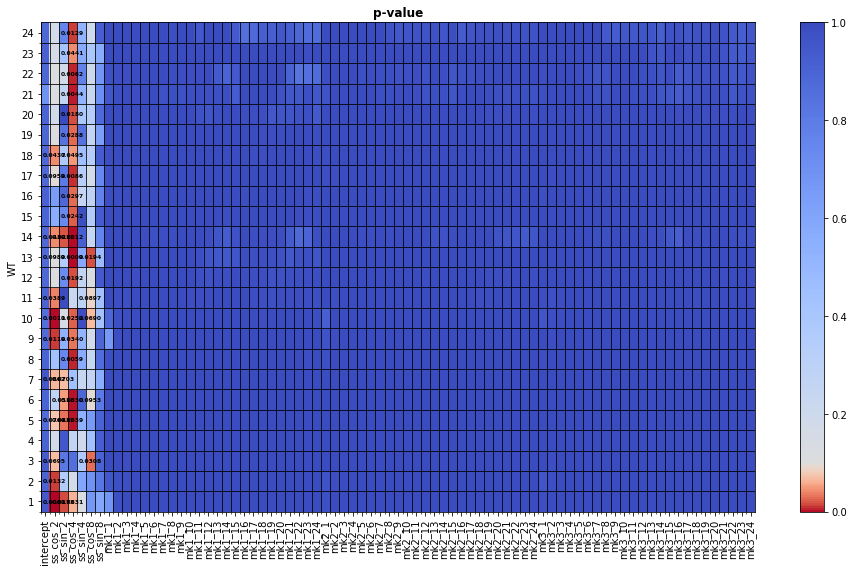

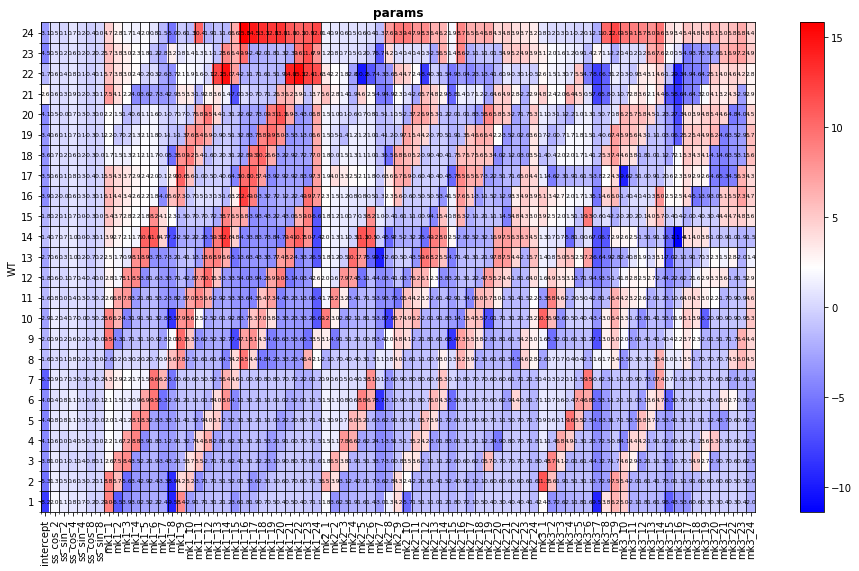

In [4]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

print(
'\nSetting ALR execution parameters...\n \
markov_order = {0}\n seasonality = {1}'.format(
    alr_markov_order, alr_seasonality)
)

# MJO historical data for fitting
num_categs  = 25  # fixed parameter
xds_bmus_fit = xr.Dataset(
    {
        'bmus'  :(('time',), xds_mjo_hist.categ.values[:]),
    },
    {'time' : xds_mjo_hist.time}
)

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'seasonality': (True, alr_seasonality),
}

# ALR wrapper
ALRW = ALR_WRP(p_mjo_alrw)
ALRW.SetFitData(num_categs, xds_bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=10000)

# show fit report
ALRW.Report_Fit()


In [5]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# simulation dates
dates_sim = [d1_sim + timedelta(days=i) for i in range((d2_sim-d1_sim).days+1)]

# launch simulation
sim_num = 1  # only one simulation for mjo daily
xds_alr = ALRW.Simulate(sim_num, dates_sim, progress_bar=False)
evbmus_sim = np.squeeze(xds_alr.evbmus_sims.values[:])


# Generate mjo rmm1 and rmm2 simulated values
print('\nGenerating MJO simulation: rmm1, rmm2 (random value withing category)...')
rmm12_sim = np.empty((len(evbmus_sim),2)) * np.nan
for c, m in enumerate(evbmus_sim):
    options = d_rmm_categ['cat_{0}'.format(int(m))]
    r = np.random.randint(options.shape[0])
    rmm12_sim[c,:] = options[r,:]

# mjo and phase
mjo_sim = np.sqrt(rmm12_sim[:,0]**2+rmm12_sim[:,1]**2)
phase_sim = np.arctan2(rmm12_sim[:,0], rmm12_sim[:,1])

# store simulated mjo
xds_MJO_sim = xr.Dataset(
    {
        'mjo'   :(('time',), mjo_sim),
        'phase' :(('time',), phase_sim),
        'rmm1'  :(('time',), rmm12_sim[:,0]),
        'rmm2'  :(('time',), rmm12_sim[:,1]),
    },
    {'time' : dates_sim}
)
print(xds_MJO_sim)

# xarray.Dataset.to_netcdf() wont work with this time array and time dtype
sbxds(xds_MJO_sim, p_mjo_sim)
print('\nMJO Simulation stored at:\n{0}'.format(p_mjo_sim))


ALR model fit   : 1979-01-01T00:00:00.000000000 --- 2018-04-08T00:00:00.000000000
ALR model sim   : 2020-01-01 --- 3020-01-01

Launching simulations...


Generating MJO simulation: rmm1, rmm2 (random value withing category)...
<xarray.Dataset>
Dimensions:  (time: 365243)
Coordinates:
  * time     (time) object 2020-01-01 2020-01-02 ... 3019-12-31 3020-01-01
Data variables:
    mjo      (time) float64 1.5 2.214 1.234 1.147 ... 1.561 2.098 1.583 1.488
    phase    (time) float64 -0.7389 -0.5751 -0.2059 ... 2.722 2.814 -2.654
    rmm1     (time) float64 -1.01 -1.204 -0.2522 ... 0.8549 0.5099 -0.6974
    rmm2     (time) float64 1.108 1.858 1.208 0.9 ... -1.916 -1.499 -1.314

MJO Simulation stored at:
/Users/nico/Projects/TESLA-kit/TeslaKit/data/sites/KWAJALEIN/MJO/MJO_sim.nc
